In [1]:
import pandas as pd
import folium
from folium.plugins import HeatMap

df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")

df = df.dropna(subset=["latitude", "longitude"])
print(f"Loaded dataset: {df.shape[0]} rows")

texas_map = folium.Map(location=[31.5, -99.0], zoom_start=6, tiles="cartodbpositron")
if "predicted_prob" in df.columns:
    heat_data = [
        [row["latitude"], row["longitude"], row["predicted_prob"]]
        for _, row in df.iterrows()
    ]
else:
    heat_data = df[["latitude", "longitude"]].values.tolist()

HeatMap(heat_data, radius=6, blur=10, min_opacity=0.3).add_to(texas_map)
texas_map.save("/work/siads_699_mads_capstone/data/models/fig_texas_overview.html")
texas_map


Loaded dataset: 1653 rows


In [2]:
regions = {
    "El Paso":      {"center": [31.77, -106.48], "zoom": 11},
    "Dallas–Fort Worth": {"center": [32.8, -96.8], "zoom": 9},
    "San Antonio":  {"center": [29.42, -98.5],  "zoom": 9},
}
for name, meta in regions.items():
    sub_df = df[
        (df["latitude"].between(meta["center"][0] - 1, meta["center"][0] + 1))
        & (df["longitude"].between(meta["center"][1] - 1, meta["center"][1] + 1))
    ]
    m = folium.Map(location=meta["center"], zoom_start=meta["zoom"], tiles="cartodbpositron")
    for _, row in sub_df.iterrows():
        color = "red" if row.get("high_risk", 0) == 1 else "blue"
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f"Risk: {row.get('high_risk',0)}",
        ).add_to(m)

    out_path = f"/work/siads_699_mads_capstone/data/models/fig_zoom_{name.replace(' ','_')}.html"
    m.save(out_path)
    print(f"Saved zoom-in map for {name}: {out_path}")


Saved zoom-in map for El Paso: /work/siads_699_mads_capstone/data/models/fig_zoom_El_Paso.html
Saved zoom-in map for Dallas–Fort Worth: /work/siads_699_mads_capstone/data/models/fig_zoom_Dallas–Fort_Worth.html
Saved zoom-in map for San Antonio: /work/siads_699_mads_capstone/data/models/fig_zoom_San_Antonio.html


In [3]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import folium
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,5)

#Load dataset
df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

numeric_cols = [
    "duration_hr", "avg_distance_km", "avg_visibility_mi",
    "avg_temp_F", "avg_wind_mph", "high_risk", "crash_count"
]
df = df[numeric_cols].copy()
df.head()


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loaded dataset: 1653 rows, 14 columns


,duration_hr,avg_distance_km,avg_visibility_mi,avg_temp_F,avg_wind_mph,high_risk,crash_count
0,23.999722,0.561889,9.772388,72.241045,8.430159,0,134
1,23.999722,0.561889,9.772388,72.241045,8.430159,0,134
2,23.999722,0.561889,9.772388,72.241045,8.430159,0,134
3,23.999722,0.561889,9.772388,72.241045,8.430159,0,134
4,23.999722,0.561889,9.772388,72.241045,8.430159,0,134


In [4]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

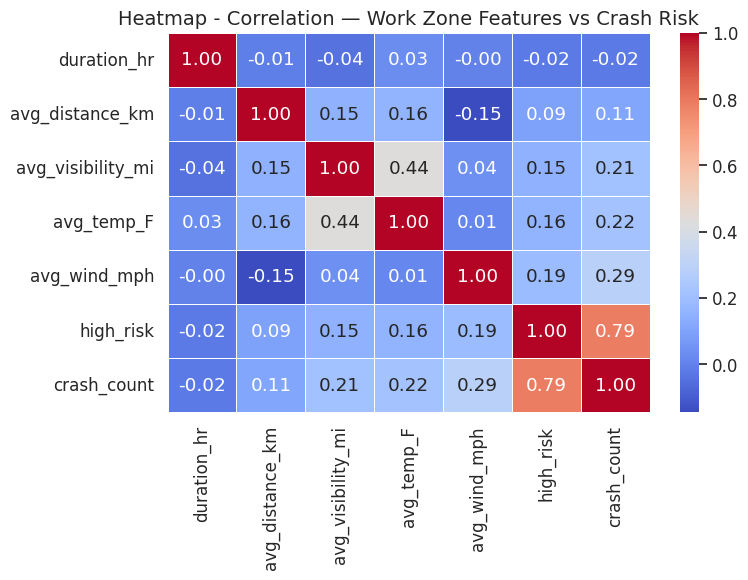

In [5]:
#Correlation
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap - Correlation — Work Zone Features vs Crash Risk", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
#Crash Hotspots
geo_df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features_clustered.csv")

m = folium.Map(location=[31.5, -99.0], zoom_start=6)
for _, row in geo_df.iterrows():
    color = "red" if row.get("high_risk", 0) == 1 else "blue"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)
m.save("/work/siads_699_mads_capstone/data/models/fig_geo_hotspots.html")
m


/tmp/ipykernel_4380/2762248958.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x=models, y=auc_scores, palette="viridis")


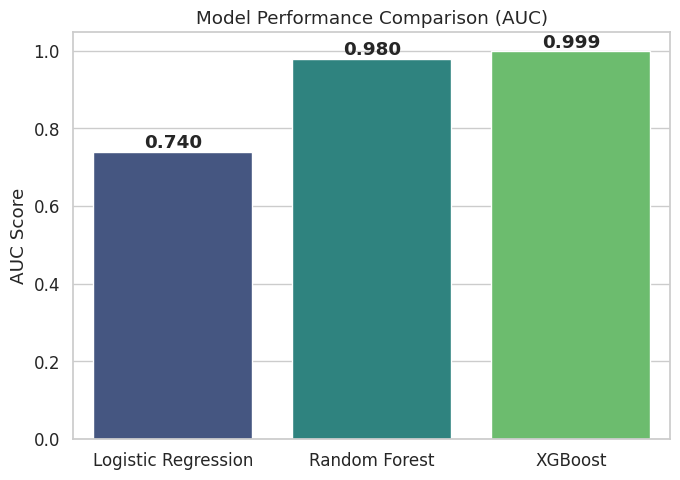

In [7]:

models = ["Logistic Regression", "Random Forest", "XGBoost"]
auc_scores = [0.74, 0.98, 0.999]
f1_scores = [0.74, 0.76, 0.96]

fig, ax = plt.subplots(figsize=(7,5))
bar = sns.barplot(x=models, y=auc_scores, palette="viridis")
plt.title("Model Performance Comparison (AUC)")
plt.ylabel("AUC Score")
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()



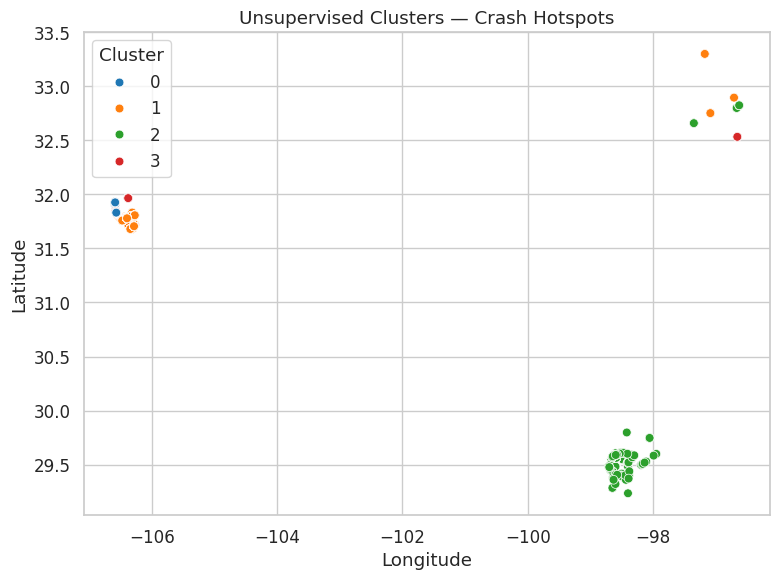

In [8]:
#KMeans clustering
features = ["latitude", "longitude", "avg_visibility_mi", "avg_temp_F", "avg_wind_mph"]
geo_df = geo_df.dropna(subset=features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(geo_df[features])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
geo_df["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=geo_df, x="longitude", y="latitude",
    hue="cluster", palette="tab10", s=40
)
plt.title("Unsupervised Clusters — Crash Hotspots")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>